# Import Packages

In [24]:
# Import packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)


# For metrics and helpful functions for Logistic Regression

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve

# For saving models
import pickle

## Load Dataset (and some preliminary analysis)

In [3]:
# Load dataset into a dataframe

df0 = pd.read_csv(r'/Users/apple/Documents/data projects/Employee Churn at Salifort Motors/Data/HR_dataset.csv')

# Display first few rows of the dataframe

df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
# Basic information about the data

df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
# To display all column names

df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [6]:
# Rename columns for easier use
df0 = df0.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})

# Display all the new column names 
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [7]:
# Drop duplicates and save resulting dataframe in a new variable.
df1 = df0.drop_duplicates(keep='first')

# Display first few rows of new dataframe.
df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# Logistic Regression model 


**Logistic Regression model assumptions are **
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables 
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size

Our goal is to predict whether an employee leaves the company, which is a categorical outcome variable. So this task involves classification. More specifically, this involves binary classification, since the outcome variable `left` can be either 1 (indicating employee left) or 0 (indicating employee didn't leave). 

#### Binomial logistic regression suits the task because it involves binary classification.

In [17]:
# to Copy the dataframe
df_enc = df1.copy()

# Encode the `salary` column as an ordinal numeric category
df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

# Dummy encode the `department` column 
# (`department` is a categorical variable, which means you can dummy it for modeling.)
df_enc = pd.get_dummies(df_enc, drop_first=False)

# Display the new dataframe
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


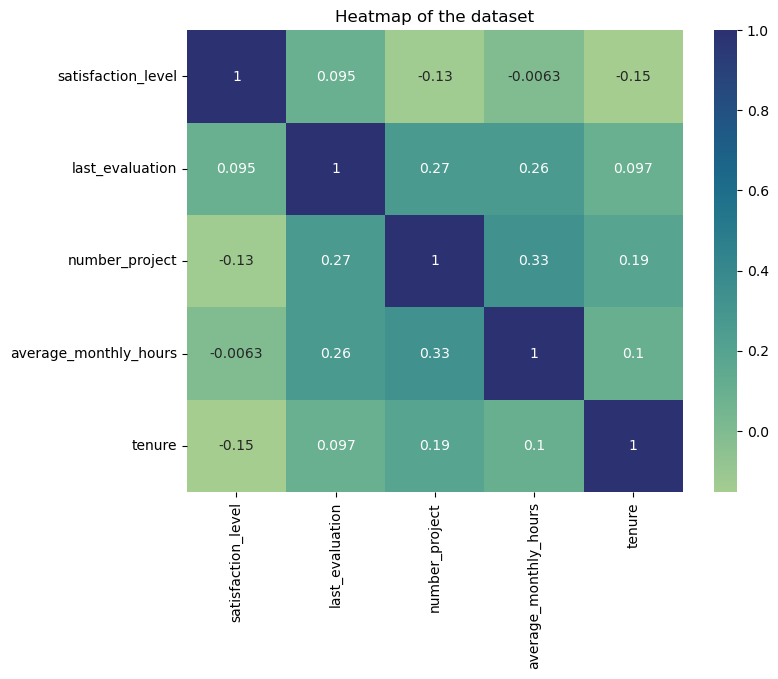

In [11]:
# Creating a heatmap to visualize how correlated variables are in above data frame
plt.figure(figsize=(8, 6))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

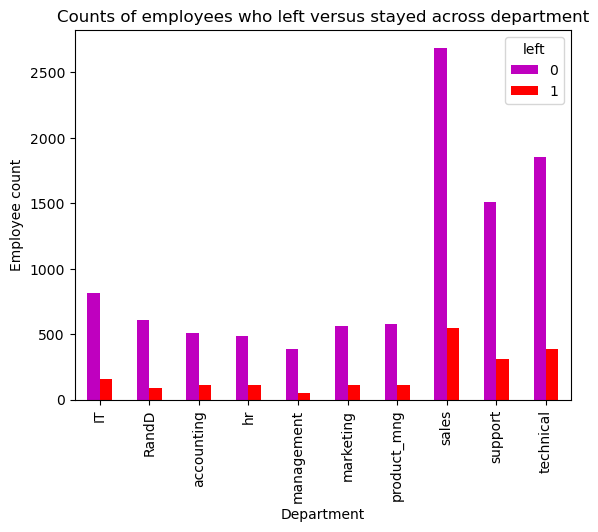

In [12]:
# Create a stacked bart plot to visualize number of employees across department, comparing those who left with those who didn't
# In the legend, 0 (purple color) represents employees who did not leave, 1 (red color) represents employees who left
pd.crosstab(df1['department'], df1['left']).plot(kind ='bar',color='mr')
plt.title('Counts of employees who left versus stayed across department')
plt.ylabel('Employee count')
plt.xlabel('Department')
plt.show()

In [14]:
# Compute the 25th percentile value in `tenure`
percentile25 = df1['tenure'].quantile(0.25)

# Compute the 75th percentile value in `tenure`
percentile75 = df1['tenure'].quantile(0.75)

# Compute the interquartile range in `tenure`
iqr = percentile75 - percentile25

# Define the upper limit and lower limit for non-outlier values in `tenure`
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Select rows without outliers in `tenure` and save resulting dataframe in a new variable
df_logreg = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)]

# Display first few rows of new dataframe
df_logreg.head()

Lower limit: 1.5
Upper limit: 5.5


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [15]:
# Lets Isolate the outcome variable
y = df_logreg['left']

# Display first few rows of the outcome variable
y.head() 

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

In [16]:
# Select the features you want to use in your model
X = df_logreg.drop('left', axis=1)

# Display the first few rows of the selected features 
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,0,0,False,False,False,False,False,False,False,True,False,False


In [18]:
# Now , split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

Lets Construct a logistic regression model and fit it to the training dataset(we are actually training the model using train data).

In [19]:
# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

Lets test the logistic regression model and use the model to make predictions on the test set(testing the model outputs from the new test data).

In [20]:
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test)

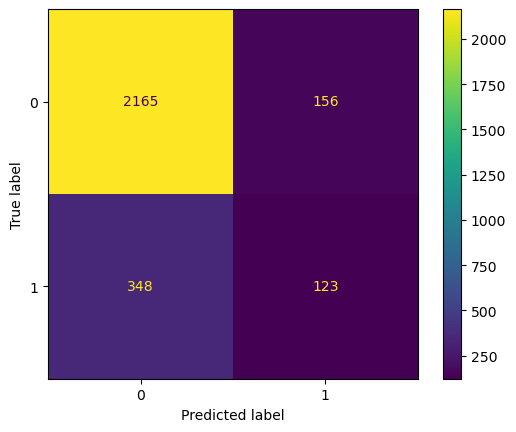

In [21]:
# Compute values for confusion matrix(to visualize the results of the logistic regression model)
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()

### obsevations from the above confusion matrix
The upper-left quadrant displays the number of true negatives.
The upper-right quadrant displays the number of false positives.
The bottom-left quadrant displays the number of false negatives.
The bottom-right quadrant displays the number of true positives.

True negatives: The number of people who did not leave that the model accurately predicted did not leave.

False positives: The number of people who did not leave the model inaccurately predicted as leaving.

False negatives: The number of people who left that the model inaccurately predicted did not leave

True positives: The number of people who left the model accurately predicted as leaving

In [22]:
df_logreg['left'].value_counts(normalize=True)

left
0    0.831468
1    0.168532
Name: proportion, dtype: float64

There is an approximately 83%-17% split.

In [23]:
# Create classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.44      0.26      0.33       471

                 accuracy                           0.82      2792
                macro avg       0.65      0.60      0.61      2792
             weighted avg       0.79      0.82      0.80      2792



## what are the results of the above model

The classification report above shows that the logistic regression model achieved a precision of 79%, recall of 82%, f1-score of 80% (all weighted averages), and accuracy of 82%. However, if it's most important to predict employees who leave, then the scores are significantly lower.